In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pomegranate as pom
import pickle
import multiprocessing

In [2]:
import import_ipynb
import readSequenceFunctions as rsf
from baseHMM import createModel3S

importing Jupyter notebook from readSequenceFunctions.ipynb
importing Jupyter notebook from baseHMM.ipynb
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.25 µs
{
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "1" :0.3,
            "2" :0.5,
            "0" :0
        }
    ],
    "class" :"Distribution",
    "name" :"DiscreteDistribution",
    "frozen" :false
}
{
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "1" :0.29,
            "2" :0.51,
            "0" :0
        }
    ],
    "class" :"Distribution",
    "name" :"DiscreteDistribution",
    "frozen" :false
}
{
    "dtype" :"int",
    "parameters" :[
        {
            "3" :0.2,
            "1" :0.3,
            "2" :0.5,
            "0" :0
        }
    ],
    "class" :"Distribution",
    "name" :"DiscreteDistribution",
    "frozen" :false
}
{
    "dtype" :"int",
    "parameters" :[

In [3]:
np.set_printoptions(precision=5, linewidth=120, suppress=True)

## Dataset

actualCoding=1
rsf.usedCoding.changeCoding(actualCoding)

seqDict,seqDictT,trainList,trainNamesList,testList,testNamesList=\
        rsf.traindAndTestDataset(rsf.pathsBCE, testSize=50)

## Initialization of HMM

In [4]:
def randomDistr(n, generator=None):
    """Create random DiscreteDistribution, which create integers from 0 to n-1"""
    d={}
    if generator is not None:
        generatedList=generator.uniform(size=n)
    else:
        generatedList=np.random.rand(n)
    sumOfList=np.sum(generatedList)
    generatedList/=sumOfList
    for i in range(n):
        d[i]=generatedList[i]
    return pom.DiscreteDistribution(d)

In [5]:
def emptyDistr(n):
    """Create DiscreteDistribution which generate nothing, with possible value from 0 to n-1."""
    d={}
    for i in range(n):
        d[i]=0
    return pom.DiscreteDistribution(d)

In [6]:
def endDistr(n):
    """Crete DiscreteDistribution which generate only stop codons."""
    d={}
    for i in range(n):
        d[i]=0
    d[rsf.usedCoding.stopCodonsSymbol]=1
    return pom.DiscreteDistribution(d)

In [15]:
def initializeHMM(n=100, initialEnd=0.01, generator=None):
    #testGenerator=np.random.default_rng(seed=20200201)
    
    distrList=[emptyDistr(4)]*n
    distrList[0]=endDistr(4)
    distrList[1]=randomDistr(4,generator=generator)

    #state 0 generate end
    #state 1 is initial only generating state
    transMatrix=np.zeros((n,n))
    transMatrix[1,1]=1-initialEnd
    transMatrix[1,0]=initialEnd
    
    start=np.zeros(n)
    start[1]=1
    
    end=np.zeros(n)
    end[0]=1

    return pom.HiddenMarkovModel.from_matrix(transMatrix,distrList,start,end)

## Spliting states

In [8]:
def entropy(distr):
    if not isinstance(distr, pom.DiscreteDistribution):
        raise RuntimeError("Entropy becamed distribution diffrent from pom.DiscreteDistribution")
    probability=distr.parameters[0]
    ent=0
    for key,prob in probability.items():
        if prob!=0:
            ent+=prob*np.log(prob)
    ent*=(-1)
    return ent

In [9]:
def splitDistribution(distr, generator=None):
    """Split distr in two distribution such that distr=alfa*distr1+(1-alfa)*distr2"""
    keys=distr.keys()
    probabilities=np.array(distr.values())
    if generator is not None:
        relations=generator.uniform(low=0, high=1, size=len(keys))
    else:
        relations=np.random.rand(len(keys))
    
    prob1=probabilities*relations
    prob2=probabilities-prob1
    
    alfa=np.sum(prob1)
    
    prob1/=alfa
    prob2/=(1-alfa)
    
    d1={}
    d2={}
    
    for i in range(len(keys)):
        d1[keys[i]]=prob1[i]
        d2[keys[i]]=prob2[i]
    
    return(alfa,pom.DiscreteDistribution(d1),pom.DiscreteDistribution(d2))

In [10]:
def splitState(model, generator=None):
    maxIndex=-1;
    maxEntr=-1;
    startIndex=None
    endIndex=None
    distributions=[model.states[0].distribution]
    for i in range(1,len(model.states)):
        if model.states[i].name=="None-start":
            startIndex=i
            distributions.append(model.states[i].distribution)
            continue
        if model.states[i].name=="None-end":
            endIndex=i
            distributions.append(model.states[i].distribution)
            continue
        distributions.append(model.states[i].distribution)
        ent=entropy(model.states[i].distribution)
        if maxEntr<ent:
            maxEntr=ent
            maxIndex=i
    (alfa, distr1, distr2)=splitDistribution(model.states[maxIndex].distribution, generator=generator)
    
    #print("Alfa:",alfa)
    
    distributions[maxIndex]=distr1
    distributions.append(distr2)
    
    matrix=np.copy(model.dense_transition_matrix())
    matrix=np.vstack((matrix,np.zeros(matrix.shape[0])))
    matrix=np.hstack((matrix,np.zeros((matrix.shape[0],1))))
    
    #copy in probabilities
    matrix[:,-1]=matrix[:,maxIndex]
    
    #copy out probabilities
    matrix[-1,:]=matrix[maxIndex,:]
    
    #modify in probabilities with alfa
    matrix[:,maxIndex]*=alfa
    matrix[:,-1]*=(1-alfa)
    
    #save list of transition from start and to stop
    end=np.copy(matrix[:,endIndex])
    start=np.copy(matrix[startIndex,:])
    
    #remove state-stop and state-start
    matrix[:,endIndex]=np.zeros(matrix.shape[0])
    matrix[startIndex,:]=np.zeros(matrix.shape[1])
    
   # print(matrix)
   # print(len(distributions))
   # print(start)
   # print(end)
    return pom.hmm.HiddenMarkovModel.from_matrix(matrix, distributions, start,end)

In [11]:
def createStates(model, learningList, testingList, n=32,stopTreshold=10, verbose=0,
                savePrefix="Modele/m"):
    if verbose>=2:
        fitVerbose=True
    else:
        fitVerbose=False    
    
    testGenerator=np.random.default_rng(seed=2020020114)
    
    results1=[]
    results3=[]
    model.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
    
    with open(savePrefix+"0.store","wb") as file:
        pickle.dump(model,file)
        
    scores1S=[model.log_probability(seq) for seq in testingList]
    scores1S=np.array(scores1S)
    
    if verbose>=3:
        print(model.dense_transition_matrix())
    
    model3S=createModel3S(1)
    model3S.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
    
    scores3S=[model3S.log_probability(seq) for seq in testingList]
    scores3S=np.array(scores3S)
    
    for i in range(1,n):
        model=splitState(model,generator=testGenerator)
        if n>15:
            model.fit(learningList,stop_threshold=stopTreshold, n_jobs=-1, verbose=fitVerbose)
        else:
            model.fit(learningList,stop_threshold=stopTreshold, verbose=fitVerbose)
        
        scoresModel=[model.log_probability(seq) for seq in testingList]
        scoresModel=np.array(scoresModel)
        scoresModel1=scoresModel-scores1S
        scoresModel3=scoresModel-scores3S
        results1.append(np.mean(scoresModel1))
        results3.append(np.mean(scoresModel3))
        
        with open(savePrefix+str(i+1)+".store","wb") as file:
            pickle.dump(model,file)
            
        if verbose>=1:
            print("End of step:",i+1)
        
        if verbose>=3:
            print(model.dense_transition_matrix())
        
    return {"results1":results1,"results3":results3,"scores1":scores1S,"scores3":scores3S}

In [16]:
def mpUnitTest(generator, n):
    seqDict,seqDictT,trainList,trainNamesList,testList,testNamesList=\
                    rsf.traindAndTestDataset(rsf.pathsBCE, testSize=400, generator=generator)
    result=createStates(initializeHMM(generator=generator),trainList,testList,n=7,
                        savePrefix="Modele/m-"+str(n)+"-", verbose=2,stopTreshold=10)
        
    with open("Modele/result-"+str(n),"wb") as file:
        pickle.dump(result,file)
    return

In [17]:
def test():
    actualCoding=1
    rsf.usedCoding.changeCoding(actualCoding)

    generators=[np.random.default_rng(100240),np.random.default_rng(100250),np.random.default_rng(100255),
               np.random.default_rng(100315)]
    inputData=zip(generators,range(1,4))
    with multiprocessing.Pool(4) as pool:
        pool.starmap(mpUnitTest,inputData)
            

In [18]:
test()

[1] Improvement: 1766640.9751619603	Time (s): 2.771
[1] Improvement: 1772314.5420176561	Time (s): 2.805
[1] Improvement: 1780813.5049679363	Time (s): 2.822
[2] Improvement: 2.491287887096405e-08	Time (s): 2.81
Total Training Improvement: 1766640.9751619853
Total Training Time (s): 8.3944
[2] Improvement: -1.096632331609726e-07	Time (s): 2.837
Total Training Improvement: 1772314.5420175465
Total Training Time (s): 8.4615
[2] Improvement: -2.3283064365386963e-08	Time (s): 2.856
Total Training Improvement: 1780813.504967913
Total Training Time (s): 8.5399
[1] Improvement: 21194.81385919801	Time (s): 4.258
[1] Improvement: 21411.70058193989	Time (s): 4.29
[1] Improvement: 21228.053497879533	Time (s): 4.29
[2] Improvement: 177.66972137871198	Time (s): 4.247
[2] Improvement: 177.082697537262	Time (s): 4.29
[2] Improvement: 177.98906606598757	Time (s): 4.278
[3] Improvement: 132.19799650576897	Time (s): 4.275
[3] Improvement: 131.55727434833534	Time (s): 4.3
[3] Improvement: 130.7216521571390

[9] Improvement: 10.284691396867856	Time (s): 4.27
[10] Improvement: 10.221699048765004	Time (s): 4.173
[11] Improvement: 9.996651601977646	Time (s): 4.344
Total Training Improvement: 117.00216085114516
Total Training Time (s): 50.5923
End of step: 1
[10] Improvement: 10.167901902925223	Time (s): 4.262
[11] Improvement: 10.105598448077217	Time (s): 4.326
[11] Improvement: 10.051395467948169	Time (s): 4.499
[12] Improvement: 9.988540936261415	Time (s): 4.246
Total Training Improvement: 128.10772426053882
Total Training Time (s): 55.3163
End of step: 1
[12] Improvement: 9.933960787951946	Time (s): 4.079
Total Training Improvement: 127.43938751262613
Total Training Time (s): 55.7005
End of step: 1
[1] Improvement: 29.92183937993832	Time (s): 6.683
[2] Improvement: 23.50095244217664	Time (s): 6.265
[1] Improvement: 29.19865140528418	Time (s): 6.344
[1] Improvement: 28.61698946543038	Time (s): 6.34
[3] Improvement: 18.870717726415023	Time (s): 6.449
[2] Improvement: 23.02403792599216	Time (

[35] Improvement: 35.447716823546216	Time (s): 11.99
[35] Improvement: 32.49690720695071	Time (s): 12.24
[36] Improvement: 27.1345163367223	Time (s): 12.26
[36] Improvement: 32.34216294484213	Time (s): 13.19
[36] Improvement: 29.43672243040055	Time (s): 14.28
[37] Improvement: 24.128212590701878	Time (s): 13.69
[37] Improvement: 29.23323106369935	Time (s): 13.49
[37] Improvement: 26.462806299328804	Time (s): 14.15
[38] Improvement: 21.394463000120595	Time (s): 13.9
[38] Improvement: 26.233000581385568	Time (s): 13.2
[38] Improvement: 23.66432821121998	Time (s): 13.3
[39] Improvement: 18.966409349814057	Time (s): 13.95
[39] Improvement: 23.42592253978364	Time (s): 13.24
[39] Improvement: 21.10185085562989	Time (s): 13.5
[40] Improvement: 16.85173493134789	Time (s): 13.52
[40] Improvement: 20.86757631530054	Time (s): 13.26
[40] Improvement: 18.80905771860853	Time (s): 12.99
[41] Improvement: 15.039346570381895	Time (s): 13.68
[41] Improvement: 18.587057450553402	Time (s): 13.11
[41] Impr

[16] Improvement: 12.076534673105925	Time (s): 23.69
[14] Improvement: 13.30148748238571	Time (s): 24.24
[17] Improvement: 11.31865985924378	Time (s): 22.26
[17] Improvement: 11.462541224202141	Time (s): 22.03
[15] Improvement: 12.643578820163384	Time (s): 22.22
[18] Improvement: 10.817623547976837	Time (s): 21.89
[18] Improvement: 10.88564968132414	Time (s): 21.78
[16] Improvement: 12.02176766260527	Time (s): 21.9
[19] Improvement: 10.337841022759676	Time (s): 21.65
[19] Improvement: 10.343903752276674	Time (s): 21.76
[17] Improvement: 11.434504619101062	Time (s): 21.98
[20] Improvement: 9.879036848898977	Time (s): 21.56
Total Training Improvement: 333.04105280619115
Total Training Time (s): 459.5192
End of step: 6
[20] Improvement: 9.835246153408661	Time (s): 22.36
Total Training Improvement: 348.19284651777707
Total Training Time (s): 459.5328
End of step: 6
[18] Improvement: 10.880446201656014	Time (s): 21.39
[19] Improvement: 10.35819438751787	Time (s): 20.42
[20] Improvement: 9.8

In [21]:
with open("Modele/result-1","rb") as file:
        result1=pickle.load(file)
with open("Modele/result-2","rb") as file:
        result2=pickle.load(file)
with open("Modele/result-3","rb") as file:
        result3=pickle.load(file)

Text(0, 0.5, 'Średnia różnic między modelem analizowanym, a M0')

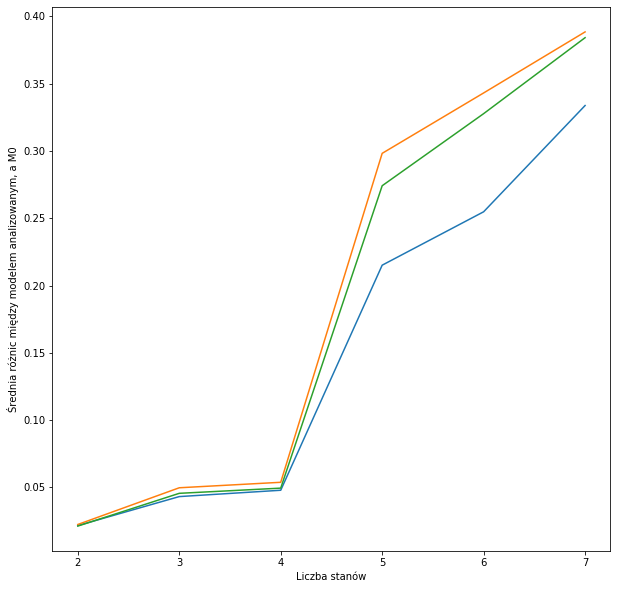

In [32]:
plt.gcf().set_size_inches(10,10)
plt.plot(range(2,8),result1["results1"])
plt.plot(range(2,8),result2["results1"])
plt.plot(range(2,8),result3["results1"])
plt.xlabel("Liczba stanów")
plt.ylabel("Średnia różnic między modelem analizowanym, a M0")

Text(0, 0.5, 'Średnia różnic między modelem analizowanym, a M3')

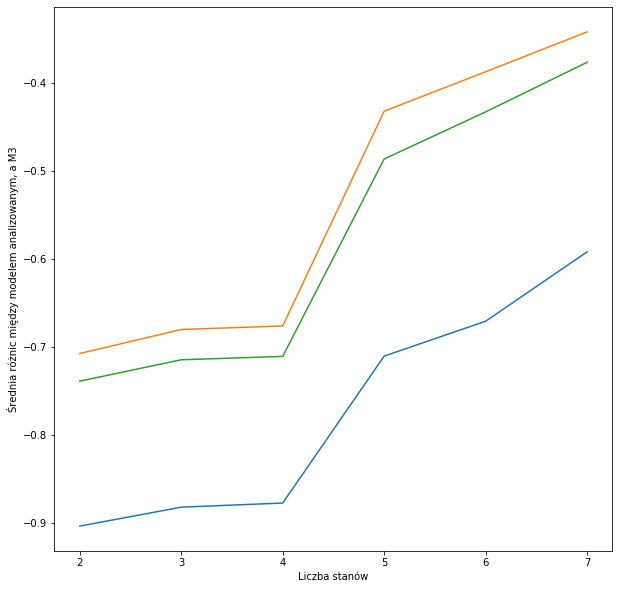

In [33]:
plt.gcf().set_size_inches(10,10)
plt.plot(range(2,8),result1["results3"])
plt.plot(range(2,8),result2["results3"])
plt.plot(range(2,8),result3["results3"])
plt.xlabel("Liczba stanów")
plt.ylabel("Średnia różnic między modelem analizowanym, a M3")

In [39]:
R1=result1["scores3"]-result1["scores1"]
R2=result2["scores3"]-result2["scores1"]
R3=result3["scores3"]-result3["scores1"]

In [42]:
print(np.mean(R1))
print(np.mean(R2))
print(np.mean(R3))

0.9256181407880655
0.7300034854064862
0.760309717073915


|Próba|Średnia różnica między M3 a M0|
|-|-|
|1|0.9256|
|2|0.7300|
|3|0.7603|

Text(0, 0.5, 'Różnica na kolejnych sekwencjach testowych między M0 a M3')

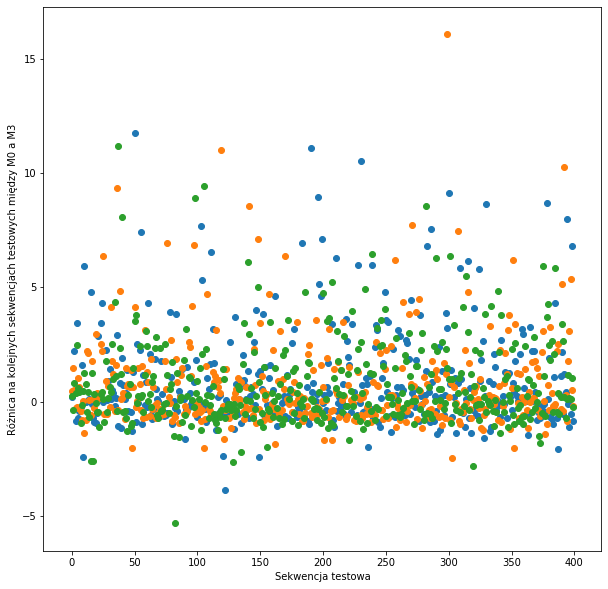

In [57]:
plt.gcf().set_size_inches(10,10)
plt.scatter(range(400),R1)
plt.scatter(range(400),R2)
plt.scatter(range(400),R3)
plt.xlabel("Sekwencja testowa")
plt.ylabel("Różnica na kolejnych sekwencjach testowych między M0 a M3")

In [50]:
with open("Modele/m-1-7.store","rb") as file:
        m7=pickle.load(file)

m7.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00075, 0.55721, 0.08356, 0.03629, 0.05385, 0.04426, 0.07905, 0.14504, 0.     , 0.     ],
       [0.00649, 0.56127, 0.09748, 0.0294 , 0.05239, 0.03547, 0.0826 , 0.1349 , 0.     , 0.     ],
       [0.00127, 0.52824, 0.08656, 0.02324, 0.03355, 0.03535, 0.09464, 0.19715, 0.     , 0.     ],
       [0.     , 0.54975, 0.0707 , 0.04727, 0.05181, 0.05815, 0.06874, 0.15358, 0.     , 0.     ],
       [0.00437, 0.5113 , 0.08585, 0.01242, 0.02961, 0.01822, 0.10275, 0.23549, 0.     , 0.     ],
       [0.00952, 0.55465, 0.08449, 0.01762, 0.04758, 0.02119, 0.09841, 0.16654, 0.     , 0.     ],
       [0.00874, 0.54447, 0.07451, 0.01174, 0.04376, 0.01395, 0.08395, 0.2189 , 0.     , 0.     ],
       [0.     , 0.10028, 0.00009, 0.     , 0.86183, 0.     , 0.00019, 0.03761, 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [51]:
with open("Modele/m-1-4.store","rb") as file:
        m4=pickle.load(file)

m4.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00267, 0.56472, 0.32691, 0.02672, 0.07898, 0.     , 0.     ],
       [0.00492, 0.56557, 0.32848, 0.02533, 0.0757 , 0.     , 0.     ],
       [0.00257, 0.56689, 0.33335, 0.02388, 0.07331, 0.     , 0.     ],
       [0.00212, 0.56638, 0.32957, 0.02578, 0.07616, 0.     , 0.     ],
       [0.     , 0.89462, 0.10364, 0.00005, 0.00168, 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [52]:
with open("Modele/m-1-5.store","rb") as file:
        m5=pickle.load(file)

m5.dense_transition_matrix()

array([[0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 1.     ],
       [0.00088, 0.55994, 0.31734, 0.0323 , 0.05039, 0.03915, 0.     , 0.     ],
       [0.00818, 0.56107, 0.34195, 0.01924, 0.04668, 0.02289, 0.     , 0.     ],
       [0.00142, 0.54284, 0.36821, 0.02191, 0.03501, 0.03062, 0.     , 0.     ],
       [0.00002, 0.53986, 0.2756 , 0.05972, 0.04997, 0.07484, 0.     , 0.     ],
       [0.00443, 0.53474, 0.39482, 0.01419, 0.03288, 0.01894, 0.     , 0.     ],
       [0.     , 0.25301, 0.00245, 0.     , 0.74454, 0.     , 0.     , 0.     ],
       [0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     , 0.     ]])

In [53]:
m5.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.0,
                 "1" : 0.0,
                 "2" : 0.0,
                 "3" : 1.0
             }
         ],
         "frozen" : false
     },
     "name" : "s0",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.6842567366371178,
                 "1" : 0.23945670376317535,
                 "2" : 0.07628655959971029,
                 "3" : 0.0
             }
         ],
         "frozen" : false
     },
     "name" : "s1",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "Di

In [54]:
m7.states

[{
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.0,
                 "1" : 0.0,
                 "2" : 0.0,
                 "3" : 1.0
             }
         ],
         "frozen" : false
     },
     "name" : "s0",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "DiscreteDistribution",
         "parameters" : [
             {
                 "0" : 0.6972693977614169,
                 "1" : 0.22921951570180732,
                 "2" : 0.0735110865367787,
                 "3" : 0.0
             }
         ],
         "frozen" : false
     },
     "name" : "s1",
     "weight" : 1.0
 }, {
     "class" : "State",
     "distribution" : {
         "class" : "Distribution",
         "dtype" : "int",
         "name" : "Dis